In [6]:
import numpy as np

import scipy as sc

import astropy
from astropy import units as u
from astropy import units

import galpy
import galpy.df
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, vcirc
from galpy.potential import SoftenedNeedleBarPotential, DehnenSmoothWrapperPotential, evaluatePotentials, evaluateSurfaceDensities
from galpy.actionAngle import actionAngleAdiabatic, actionAngleStaeckel
from galpy.util import conversion
from galpy.util.plot import dens2d
from galpy.potential import plotPotentials, plotRotcurve

from matplotlib.pyplot import *
from matplotlib import pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', **{'family':'Computer Modern','size':20})
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
from matplotlib import colors as mc
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib inline

In [7]:
### Important scale factors

# Scales to be use for conversion from natural coordinates
ro = 8. # (kpc) scale radii
vo = 220. # (km/s) scale velocity at ro

# Set model parameters for potentials and DF:
hro  = 1./3.   # Scale length for surface density
sro  = 0.16    # Radial velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)
szo  = sro/2   # Vertical velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)
hsro = 3*hro   # Radial scale length for radial velocity dispersion profile
hszo = hsro    # Radial scale length for vertical velocity dispersion profile

# Set parameters for initial conditions
nsample = 1000     # number of samples
nbatch = 10       # number of batches of nsample orbits
rmin = 0.375      # sets scaled rmin = 3 kpc
rmax = 1.125      # sets sclaed rmax = 9 kpc
zmax = 0.3        # sets scales zmax = 2.4 kpc
AAType = 'stklAA' # Action Angle approx for ICs/ This is the default parameter with a fixed delta (we can change delta parameter)
##### https://docs.galpy.org/en/latest/actionAngle.html?highlight=staeckel%20#action-angle-coordinates-using-the-staeckel-approximation #####
##### Search for Orbit Instances #####


In [8]:
### Set up underlying initial axi-symmetric potential for the disk

dpType = 'MW14'
mwp = MWPotential2014

In [9]:
### Set up the growing bar potential
# The Dehnen bar potential is initialized to start bar formation four bar periods before the 
# present day and to have completely formed the bar two bar periods ago. 
# We can integrate back to the time before bar-formation:

# Set up the Dehnen bar potential
rbo = 0.5 # rbo = 4 kpc # 0.625 # Bar length is in natural units (set to 5 kpc - Li+2016 at 6.7 kpc for same vo)
ao = rbo/2 # Bar half length
bo = rbo/4 # Tri-axial softening length
co = rbo/4 # Prolate softening length
simname = 'GrowBar_CR4'
CRo = 5./6 #220 km s^-1 / 33km s^-1 kpc^-1 = 20/3 kpc #(20/3 kpc) / 8 kpc = 5/6 This is in natural units # 0.8*rbo  # Corotation radius  [0.8*rbo=4kpc, 1.2*rbo=6kpc, 1.6*rbo=8kpc][Li+2015 bar pattern speed=33km/s/kpc]
v_c = vcirc(mwp, R = CRo)# v_c in natural units and it's the v_c at corotation radius
omegabo = v_c/CRo# Pattern speed based on CR #orbital freq = v_c/R : we need to figure out v_c at CR
print (omegabo*(vo/ro))
Ab = 1. # Bar strength (defaults to Ab=1)
pa = 0. # The position angle of the x axis (radians)

# Ab2=5
# bp2=SoftenedNeedleBarPotential(amp=Ab2,a=ao,b=bo,c=co,pa=pa,omegab=omegabo)
bp = SoftenedNeedleBarPotential(amp=Ab,a=ao,b=bo,c=co,pa=pa,omegab=omegabo,ro=ro,vo=vo,normalize=True)

# Initialize to start bar formation at t=0 (tform) 
# Completely formed after two bar periods (tsteady)
# Let bar evolve for 30 rotations after growth stops
Nrot = 7 #30 # Tbar to evolve #Nrot=3 evolves bar for 3 rotations after growth stops
Ngrow = 1 #2 # Tbar to grow bar # Ngrow=1 bar completely formed after one bar periods
Nequel = 0 # Tbar to equelibrate

tformo = 0#-(Nequel+Ngrow)*2.*np.pi/omegabo # Start time (four bar periods ago) 
btp = DehnenSmoothWrapperPotential(pot=bp,
                                   tform=0,#-4.*2.*np.pi/bp.OmegaP(),
                                   tsteady=Ngrow*2.*np.pi/bp.OmegaP())
# pot=[mwp,btp]
# mwp.plot(t=0,rmin=-1.5,rmax=1.5,zmin=-1.5,zmax=1.5,xy=True,justcontours=True,ncontours=3)
# mwp.plot()
# plt.show()

#tested that bp.OmegaP() and omegabo are the same and they are
barT = 2.*np.pi/omegabo # Period of rotation for the bar #orbital period

print(simname,' has CR = ',str(CRo*ro))


27.938960608583308
33.52675273029997
GrowBar_CR4  has CR =  6.666666666666667


In [5]:
##### Plot contour of bar potential #####

# # bp.plot(nrs=101,nzs=101)
# xmin = -1
# xmax = 1
# ymin = -1
# ymax = 1
# zmin = -5
# zmax = 10
# z = 0.
# rmin = 0.01
# rmax = 10
# # nrs=101
# phimin=0
# phimax=2*np.pi
# phi = np.linspace(phimin,phimax) # 0
# R = 0.5 #np.linspace(rmin,rmax)
# # z = np.linspace(zmin,zmax)

# # plt.figure()
# # plotPotentials(bp,aspect=1.,xy=True,rmin=xmin,rmax=ymax,nzs=101,nrs=101,zmin=ymin,zmax=ymax) #nzs is grid in z this will smooth out the density
# # plt.title('') #aspect ratio: make it skinny and elongated
# # plt.show()

# print('This is bp with amp=1 at R=0.5:', evaluatePotentials(bp, np.fabs(R), z, phi=phi,ro=8, vo=220,use_physical=False)) 
# # print('\n This is bp2 with amp=5 at phi=0:', evaluatePotentials(bp2,np.fabs(R),z,phi=phi,use_physical=False)) 
# phi_rz = evaluatePotentials(bp, R, z, phi=phi, ro=ro, vo=vo, use_physical=False)
# plt.figure()
# plot(phi_rz)
# plt.show()

# # sigma_rz = evaluateSurfaceDensities(bp, 0.5, z=8, phi=0.2, forcepoisson=False)
# # print('This is sigma_rz', sigma_rz)
# # phi=np.pi/2

# # print('\n This is bp with amp=1 at phi=pi/2:', evaluatePotentials(bp,np.fabs(R),z,phi=phi,use_physical=False)) 
# # print('\n This is bp2 with amp=5 at phi=pi/2:', evaluatePotentials(bp2,np.fabs(R),z,phi=phi,use_physical=False))
# # plt.figure()
# # plotPotentials(bp2,xy=True,aspect=1.,rmin=xmin,rmax=ymax,nzs=101,nrs=101,zmin=ymin,zmax=ymax)
# # bp2.plot(phi=0.2,nrs=101,nzs=101) #small amplitude = 0.05
# # plt.show()

In [6]:
##### Plot Density of bar potential #####

# bp.plotDensity(rmin=0.1,rmax=0.9,phi=0.2,zmax=0.3,zmin=-0.3,nrs=51,nzs=51)

In [7]:
##### Calculate the circular velocity at R in potential #####

# plotRotcurve(mwp,Rrange=[0.01,10.],phi=0.,ro=8,vo=220)

# vc_min = vcirc(mwp, R=rmin,vo=220) #units of v_c is km/s
# print ('This is v_c:',vc_min)

In [8]:
#####################################
#### USE THIS FROM OTHER PROCESSED ORBITS ####
#####################################

def orbitload_itr(nbatch,nsample,iteration,simname):
    Norbits = nsample*nbatch
    if iteration == 0:
        simname = 'NoBar'
        iteration = 11
        inname = './orbits/'+str(simname)+'/'+str(Norbits)+'N_qiDF_'+dpType+'p_'+AAType+'_orbits_cyl_'+str(simname)+str(iteration-1)+'.npy'
    else:
        inname = './orbits/'+str(simname)+'/'+str(Norbits)+'N_qiDF_'+dpType+'p_'+AAType+'_orbits_cyl_'+str(simname)+'_'+str(iteration-1)+'.npy'
    ICfile = np.load(inname)
    ICs = np.transpose(np.array([ICfile[0,:,-1],ICfile[3,:,-1],ICfile[4,:,-1],ICfile[2,:,-1],ICfile[5,:,-1],ICfile[1,:,-1]]))
    o = Orbit(ICs)
    return o

In [9]:
### This little calculator helps define appropriate length and spacing for integration

#barT =2.*np.pi/omegabo; omegabo = 1./CRo
TbarPhys = (barT*ro*units.kpc/(vo*units.km/units.s)).to(units.Gyr) # barT*ro/vo
tfgoal = 5*units.Gyr
print('A single bar rotation: ',TbarPhys.to(units.Myr))
print('It will rotate ',tfgoal/TbarPhys,' in ',tfgoal)
print('     That is' ,1*units.Gyr/TbarPhys, 'rotations per Gyr')
print('\n')

Ntot = Nequel+Ngrow+Nrot 
tfnat = (Ngrow+Nrot)*barT
tfPhys = (Ngrow+Nrot)*TbarPhys
print('After exactly ',Nrot+Ngrow,' rotations the final time will be:')
print('     ',tfnat, 'natural units')
print('     ',tfPhys)
print('\n')

def timescale(R,vc):
    R = R *u.kpc
    vc = vc *u.km/u.s
    T = R/vc *2 *np.pi
    return T.to(u.Myr)
dtmax = timescale(rmin*ro,vcirc(mwp,rmin,vo=vo,ro=ro))
print('Want max timestep to be '+str(np.round(dtmax/10,2)))

dtgoal = 5.0*units.Myr#0.5*units.Myr
Tperitr = 2
nitr = int(Ntot/Tperitr) #NUMBER OF ITERATIONS
ttotGyr = Ntot*TbarPhys.to(units.Myr)
x = np.round((ttotGyr)/dtgoal,2)
TNrough = TbarPhys/(dtgoal.to(units.Gyr))
TNround = 14#25 #225 #np.ceil(TNrough) #time step
ntitr = TNround*Tperitr
nttot = ntitr*nitr
print('For dt='+str(dtgoal)+' there are approximately '+str(x)+' steps over full simulation,')
print('   where one bar orbit every '+str(TNrough)+' time-steps.')
print('Setting to '+str(TNround)+' steps per one bar orbit, every step is '+str((TbarPhys/TNround).to(units.Myr)))
print('   and '+str(Ntot)+' rotations ('+str(Nequel)+' to equelibrate, '+str(Ngrow)+' to grow bar, '+str(Nrot)+' Tbar to evolve) takes '+str(Ntot*TNround)+' time-steps')
print('   For '+str(nitr)+' iterations with '+str(Tperitr)+'Tbar each, there are '+str(ntitr)+' steps per iteration.')
print('\n')

tfnatitr = barT*Tperitr
tfPhysitr = TbarPhys*Tperitr
dtMyr = ((tfPhysitr)/ntitr).to(units.Myr)

print('tfnat = '+str(tfnat)+' # Final integration time after '+str(Ntot)+' rotations in natural units')
print('tfGyr = '+str(tfPhys)+' # Final integration time after '+str(Ntot)+' rotations in Gyr')
print('nttot = '+str(nttot)+'         # Number of integration steps by final iteration')
print('tfnatitr = '+str(tfnatitr)+' # Integration time in natural units for this iteration')
print('tfPhysitr = '+str(tfPhysitr)+' # Integration time in Gyr for this iteration')
print('ntitr    = '+str(ntitr)+'    # Number of integration steps this iteration(2Tbar long)')
print('dtMyr = '+str(np.round(dtMyr,3))+' # Length of each step in Myr')
print('One bar orbit every '+str(TbarPhys/dtMyr.to(units.Gyr))+' time-steps')


A single bar rotation:  183.24619059032017 Myr
It will rotate  27.285696820723548  in  5.0 Gyr
     That is 5.45713936414471 rotations per Gyr


After exactly  8  rotations the final time will be:
      41.22978382962355 natural units
      1.4659695247225613 Gyr


Want max timestep to be 13.62 Myr
For dt=5.0 Myr there are approximately 293.19 steps over full simulation,
   where one bar orbit every 36.649238118064034 time-steps.
Setting to 14 steps per one bar orbit, every step is 13.089013613594297 Myr
   and 8 rotations (0 to equelibrate, 1 to grow bar, 7 Tbar to evolve) takes 112 time-steps
   For 4 iterations with 2Tbar each, there are 28 steps per iteration.


tfnat = 41.22978382962355 # Final integration time after 8 rotations in natural units
tfGyr = 1.4659695247225613 Gyr # Final integration time after 8 rotations in Gyr
nttot = 112         # Number of integration steps by final iteration
tfnatitr = 10.307445957405887 # Integration time in natural units for this iteration
tfPh

In [10]:
def makereadme(iteration):
    rmfile = './orbits/'+str(simname)+'/'+str(nsample*nbatch)+'N_qiDF_'+dpType+'p_'+AAType+'_'+str(simname)+'_'+str(iteration)+'_README.txt'
    rm = open(rmfile,'w+')

    from datetime import datetime
    rm.write('Created: '+str(datetime.now())+'\n')
    rm.write('galpy v1.5\n')
    rm.write('\n')

    rm.write('### Important scale factors\n')
    rm.write('\n')

    rm.write('# Scales to be use for conversion from natural coordinates\n')
    rm.write('ro = '+str(ro)+' # (kpc) scale radii\n')
    rm.write('vo = '+str(vo)+' #(km/s) scale velocity at ro\n')
    rm.write('\n')


    rm.write('# Set model parameters for potentials and DF:\n')
    rm.write('hro  = '+str(hro)+'   # Scale length for surface density\n')
    rm.write('sro  = '+str(sro)+'    # Radial velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)\n')
    rm.write('szo  = '+str(szo)+'   # Vertical velocity dispersion at ro in natural coordinates (times vo to get in physical at ro)\n')
    rm.write('hsro = '+str(hsro)+'     # Radial scale length for radial velocity dispersion profile\n')
    rm.write('hszo = '+str(hszo)+'    # Radial scale length for vertical velocity dispersion profile\n')
    rm.write('\n')


    rm.write('# Set parameters for orbital initial conditions\n')
    rm.write('nsample='+str(nsample)+'# number of samples per batch\n')
    rm.write('nbatch='+str(nbatch)+'# number of batches \n')
    rm.write('norbit='+str(nbatch*nsample)+'# number of orbits\n')
    rm.write('rmin='+str(rmin)+' # sets scaled rmin \n')
    rm.write('rmax='+str(rmax)+'      # sets sclaed rmax \n')
    rm.write('zmax='+str(zmax)+'    # sets scales zmax \n')
    rm.write('AAType = '+AAType+' # Action Angle approx for ICs\n')
    rm.write('\n')
    
    rm.write('### Set up underlying initial axi-symmetric potential for the disk\n')
    rm.write('dpType = '+dpType+'\n')
    rm.write('\n')
    
    rm.write('### Set up the growing bar potential\n')
    rm.write('# The Dehnen bar potential is initialized to start bar formation four bar periods before the\n')
    rm.write('# present day and to have completely formed the bar two bar periods ago. \n')
    rm.write('# We can integrate back to the time before bar-formation:\n')
    rm.write('\n')

    rm.write('# Set up the Dehnen bar potential\n')
    rm.write('rbo = '+str(rbo)+' # Bar length is in natural units\n')
    rm.write('ao = '+str(ao)+' # Bar half length\n')
    rm.write('bo = '+str(bo)+' # Tri-axial softening length\n')
    rm.write('co = '+str(co)+' # Prolate softening length\n')
    rm.write('CRo = '+str(CRo)+'  # Corotation radius\n')
    rm.write('omegabo = vo/CRo = '+str(omegabo)+' # Pattern speed based on CR\n')
    rm.write('Ab = '+str(Ab)+' # Bar strength (defaults to Ab=1)\n')
    rm.write('\n')

    rm.write('bp = SoftenedNeedleBarPotential(amp=Ab,a=ao,b=bo,c=co,omegab=omegabo)\n')
    rm.write('\n')

    #rm.write('# Initialize to start bar formation four bar periods before t=0 (tform) \n')
    #rm.write('# Completely formed two bar periods after start (tsteady)\n')
    #rm.write('tformo = -4.*2.*np.pi/omegabo # Start time (four bar periods ago)\n') 
    #rm.write('\n')

    rm.write('### Times relevant to integration\n')
    rm.write('Nrot = '+str(Nrot)+' # Tbar to evolve \n')
    rm.write('Ngrow = '+str(Ngrow)+' # Tbar to grow bar\n')
    rm.write('Nequel = '+str(Nequel)+' # Tbar to equelibrate (=0 when using pre-evolved population)\n')

    rm.write('A single bar rotation: '+str(TbarPhys.to(units.Myr))+'\n')
    rm.write('It will rotate '+str(tfgoal/TbarPhys)+' in '+str(tfgoal)+'\n')
    rm.write('     That is'+str(1*units.Gyr/TbarPhys)+'rotations per Gyr\n')
    rm.write('After exactly '+str(Nrot+Ngrow)+' rotations the final time will be:\n')
    rm.write('     '+str(tfnat)+'natural units\n')
    rm.write('     '+str(tfPhys)+'\n')
    rm.write('Want max timestep to be '+str(np.round(dtmax/10,2))+'\n')
    rm.write('For dt='+str(dtgoal)+' there are approximately '+str(x)+' steps over full simulation,\n')
    rm.write('   where one bar orbit every '+str(TNrough)+' time-steps.\n')
    rm.write('Setting to '+str(TNround)+' steps per one bar orbit, every step is '+str((TbarPhys/TNround).to(units.Myr))+'\n')
    rm.write('   and '+str(Ntot)+' rotations ('+str(Nequel)+' to equelibrate, '+str(Ngrow)+' to grow bar, '+str(Nrot)+' Tbar to evolve) takes '+str(Ntot*TNround)+' time-steps\n')
    rm.write('   For '+str(nitr)+' iterations with '+str(Tperitr)+'Tbar each, there are '+str(ntitr)+' steps per iteration.\n')
    rm.write('tfnat = '+str(tfnat)+' # Final integration time after '+str(Ntot)+' rotations in natural units\n')
    rm.write('tfGyr = '+str(tfPhys)+' # Final integration time after '+str(Ntot)+' rotations in Gyr\n')
    rm.write('nttot = '+str(nttot)+'         # Number of integration steps by final iteration\n')
    rm.write('tfnatitr = '+str(tfnatitr)+' # Integration time in natural units for this iteration\n')
    rm.write('tfPhysitr = '+str(tfPhysitr)+' # Integration time in Gyr for this iteration\n')
    rm.write('nt    = '+str(ntitr)+'    # Number of integration steps this iteration (2Tbar long)\n')
    rm.write('dtMyr = '+str(np.round(dtMyr,3))+' # Length of each step in Myr\n')
    rm.write('One bar orbit every '+str(TbarPhys/dtMyr.to(units.Gyr))+' time-steps\n')
    rm.write('\n')

    rm.write('### Output configurations\n')
    rm.write('Shape of final orbits array in cylindrical coordinates is '+str(np.shape(orp))+'\n')
    rm.write('   There are '+str(np.shape(orp[:,0,0])[0])+' coordinates [R,phi,z,vR,vphi,vz]\n')
    rm.write('   There are '+str(np.shape(orp[0,:,0])[0])+' orbits\n')
    rm.write('   There are '+str(np.shape(orp[0,0,:])[0])+' timestep outputs for each starting at equilibrium\n')

    rm.write('Shape of final orbits array in cartesian coordinates is '+str(np.shape(oxy))+'\n')
    rm.write('   There are '+str(np.shape(oxy[:,0,0])[0])+' coordinates [x,y,z,vx,vy,vz]\n')
    rm.write('   There are '+str(np.shape(oxy[0,:,0])[0])+' orbits\n')
    rm.write('   There are '+str(np.shape(oxy[0,0,:])[0])+' timestep outputs for each starting at equilibrium\n')


    rm.write('Shape of final actions array is '+str(np.shape(oa))+'\n')
    rm.write('   There are '+str(np.shape(oa[:,0])[0])+' coordinates [jR_f,jphi_f,jz_f,jR_o,jphi_o,jz_o]\n')
    rm.write('   There are '+str(np.shape(oa[0,:])[0])+' orbits\n')

    rm.write('\n')
    rm.write('Time lapsed to integrate and save: '+str(datetime.now()-dt0))

    rm.close()

In [1]:
### Integrate ICs [R,vR,vT(,z,vz,phi)]
### Save it and write README

from datetime import datetime

dt00 = datetime.now()
print('\033[1;34mStart time is: ',dt00)

for iteration in range(nitr):

    # Define parameter space
    ts = np.linspace(0,tfnatitr,ntitr)
    nbeg = Nequel*TNround

    # Start clock
    from datetime import datetime
    dt0 = datetime.now()
    print('\033[1;34mSetting up for iteration #'+str(iteration))

    # Set up orbits
    dt1 = datetime.now()
    print('\n')
    print('\033[0;30m   Setting up orbits')
    o = orbitload_itr(nbatch,nsample,iteration,simname)
    print('   Time lapsed to set up orbits = ', datetime.now()-dt0)

    # Integrate orbits
    dt2 = datetime.now()
    print('\n')
    print('   Integrating '+str(nsample*nbatch)+' orbits')
    if iteration < 1:
        pot = [mwp,btp]
    else:
        pot = [mwp,bp]
    o.integrate(ts,pot,method='symplec4_c') 
    print('   Time lapsed to intigrate orbits = ', datetime.now()-dt2)

    # Save orbits
    dt3 = datetime.now()
    print('\n')
    print('   Saving orbits using cylindrical coordinates')
    outnamerp = './orbits/'+str(simname)+'/'+str(nsample*nbatch)+'N_qiDF_'+dpType+'p_'+AAType+'_orbits_cyl_'+str(simname)+'_'+str(iteration)+'.npy'
    #Picking out [...] number of locations in the timestep that we want to read out: e.g. if ... has 4 inputs for time steps, you'll get a shape with 4 for time step output - [nbeg,int(ntitr/4),TNround,-1] will give the [beginning, 1/4, middle, and end] timesteps
    orp = np.array([o.R(ts[[nbeg,TNround,-1]]),o.phi(ts[[nbeg,TNround,-1]]),o.z(ts[[nbeg,TNround,-1]]),o.vR(ts[[nbeg,TNround,-1]]),o.vT(ts[[nbeg,TNround,-1]]),o.vz(ts[[nbeg,TNround,-1]])]) 
    np.save(outnamerp,orp)
    print('   Shape of final orbits array is '+str(np.shape(orp)))
    print('   There are '+str(np.shape(orp[:,0,0])[0])+' coordinates [R,phi,z,vR,vphi,vz]')
    print('   There are '+str(np.shape(orp[0,:,0])[0])+' orbits')
    print('   There are '+str(np.shape(orp[0,0,:])[0])+' timestep outputs for each')
    print('   Time lapsed to save orbits = ', datetime.now()-dt3)
    print('\n')
    print('   Saving orbits using cartesian coordinates')
    outnamexy = './orbits/'+str(simname)+'/'+str(nsample*nbatch)+'N_qiDF_'+dpType+'p_'+AAType+'_orbits_cart_'+str(simname)+'_'+str(iteration)+'.npy'
    oxy = np.array([o.x(ts[[nbeg,TNround,-1]]),o.y(ts[[nbeg,TNround,-1]]),o.z(ts[[nbeg,TNround,-1]]),o.vx(ts[[nbeg,TNround,-1]]),o.vy(ts[[nbeg,TNround,-1]]),o.vz(ts[[nbeg,TNround,-1]])])
    np.save(outnamexy,oxy)
    print('   Shape of final orbits array is '+str(np.shape(oxy)))
    print('   There are '+str(np.shape(oxy[:,0,0])[0])+' coordinates [x,y,z,vx,vy,vz]')
    print('   There are '+str(np.shape(oxy[0,:,0])[0])+' orbits')
    print('   There are '+str(np.shape(oxy[0,0,:])[0])+' timestep outputs for each')
    print('   Time lapsed to save orbits = ', datetime.now()-dt3)
    dt4 = datetime.now()
    print('\n')
    print('   Saving final actions')
    outnamea = './orbits/'+str(simname)+'/'+str(nsample*nbatch)+'N_qiDF_'+dpType+'p_'+AAType+'_actions_'+str(simname)+'_'+str(iteration)+'.npy'
    oai = np.array([o(ts[[nbeg]]).jr(mwp),o(ts[nbeg]).jp(mwp),o(ts[nbeg]).jz(mwp)])
#     oam = np.array([o(ts[TNround]).jr(mwp),o(ts[TNround]).jp(mwp),o(ts[TNround]).jz(mwp)])
    oaf = np.array([o(ts[-1]).jr(mwp),o(ts[-1]).jp(mwp),o(ts[-1]).jz(mwp)])
    oa = np.append(oaf,oai,axis=0)
    np.save(outnamea,oa)
    print('   Shape of final actions array is '+str(np.shape(oa)))
    print('   There are '+str(np.shape(oa[:,0])[0])+' coordinates [jR_f,jphi_f,jz_f,jR_o,jphi_o,jz_o]')
    print('   There are '+str(np.shape(oa[0,:])[0])+' orbits')
    print('   Time lapsed to save actions = ', datetime.now()-dt4)
    
    # Save README file
    print('\n')
    print('   Making README file')
    makereadme(iteration)
    print('\n')

    print('   Total time lapsed = ', datetime.now()-dt0)

print('   TOTAL total time lapsed = ', datetime.now()-dt00)


Start time is:  2022-02-14 01:43:50.013553


NameError: name 'nitr' is not defined

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


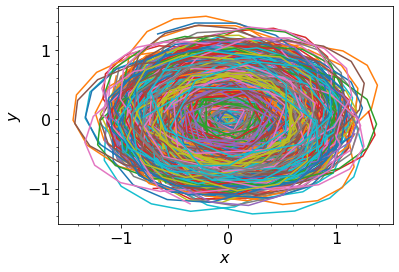

In [12]:
# a=np.arange(50)
# a[[0,-1]]

o.plot(d1='x',d2='y')

In [18]:
# o.E(pot=mwp)

array([-1.09188807, -0.84175112, -1.27167261, ..., -0.55864622,
       -0.6162801 , -0.6955349 ])

In [24]:
# print (o.Lz(ro=1,vo=1)*8*220)
# print (o.Lz(ro=8,vo=220))

[1068.11671116 1437.87919416  994.92806652 ... 2117.29695455 1795.12694294
 1880.52710291]
[1068.11671116 1437.87919416  994.92806652 ... 2117.29695455 1795.12694294
 1880.52710291]


In [33]:
# print('   Saving Vertical Angular Momentum')
# outnameLz = './orbits/'+str(simname)+'/'+str(nsample*nbatch)+'N_qiDF_'+dpType+'p_'+AAType+'_angular_momentum_z_'+str(simname)+'_'+str(0)+'.npy'
# #Picking out [...] number of locations in the timestep that we want to read out: e.g. if ... has 4 inputs for time steps, you'll get a shape with 4 for time step output - [nbeg,int(ntitr/4),TNround,-1] will give the [beginning, 1/4, middle, and end] timesteps
# olz = np.array([o.Lz(ro=1,vo=1)])
# np.save(outnameLz,olz)
# print('   Shape of final Jacobi Energy array is '+str(np.shape(olz)))

   Saving Vertical Angular Momentum
   Shape of final Jacobi Energy array is (1, 10000)


In [27]:
# o.Jacobi(OmegaP=omegabo,pot=mwp,vo=220)

array([-88657.86729755, -88948.17429109, -94905.66173601, ...,
       -98024.56829241, -90012.73379609, -96711.85623935])

In [32]:
# print('   Saving Jacobi Energy')
# outnameEJ = './orbits/'+str(simname)+'/'+str(nsample*nbatch)+'N_qiDF_'+dpType+'p_'+AAType+'_jacobi_energy_'+str(simname)+'_'+str(0)+'.npy'
# #Picking out [...] number of locations in the timestep that we want to read out: e.g. if ... has 4 inputs for time steps, you'll get a shape with 4 for time step output - [nbeg,int(ntitr/4),TNround,-1] will give the [beginning, 1/4, middle, and end] timesteps
# oj = np.array([o.Jacobi(OmegaP=omegabo,pot=mwp,vo=220)])
# np.save(outnameEJ,oj)
# print('   Shape of final Jacobi Energy array is '+str(np.shape(oj)))

   Saving Jacobi Energy
   Shape of final Jacobi Energy array is (1, 10000)


In [13]:
# plt.semilogy(o(ts[-1]).jr(mwp)/o(ts[0]).jr(mwp))

In [14]:
# plt.semilogy(oa[0,:]/oa[3,:])

In [15]:
#####################################
#### USE THIS FOR FIXED z values ####
#####################################

# def orbitsetup(nbatch,nsample):
#     ICs = None
#     for ibatch in range(nbatch):
#         inname = './ICs/sample_'+str(nsample)+'N_qiDF_'+dpType+'p_'+AAType+'_'+str(ibatch)+'.npy'
#         ICfile = np.load(inname)
#         if ICs is None:
#             ICs = np.array([
#                 [ ICfile[ii,0],ICfile[ii,3],ICfile[ii,4],ICfile[ii,2],ICfile[ii,5],ICfile[ii,1] ]
#                 for ii in range(nsample) ])
#         else:
#             ICs = np.append(ICs,
#                             np.array([
#                             [ ICfile[ii,0],ICfile[ii,3],ICfile[ii,4],ICfile[ii,2],ICfile[ii,5],ICfile[ii,1] ]
#                             for ii in range(nsample) ]),
#                             axis=0)        
#     o = Orbit(ICs)
#     return o

In [16]:
#####################################################
#### THIS IS TO FIX z to include negative values ####
#### TOGGLE OFF AFTER FIXED IN GENERATION CODE   ####
#####################################################

# def orbitsetup(nbatch,nsample):
#     ICs = None
#     for ibatch in range(nbatch):
#         inname = './ICs/sample_'+str(nsample)+'N_qiDF_'+dpType+'p_'+AAType+'_'+str(ibatch)+'.npy'
#         ICfile = np.load(inname)

#         archivename = './ICs/badz/sample_'+str(nsample)+'N_qiDF_'+dpType+'p_'+AAType+'_'+str(ibatch)+'.npy'
#         np.save(archivename,ICfile)

#         if ICs is None:
#             ICs = np.array([
#                 [ ICfile[ii,0],ICfile[ii,3],ICfile[ii,4],ICfile[ii,2]*np.random.choice((1,-1)),ICfile[ii,5],ICfile[ii,1] ]
#                 for ii in range(nsample) ])
#             UpdatedICs = np.array([
#                 [ ICfile[ii,0],ICfile[ii,1],ICfile[ii,2]*np.random.choice((1,-1)),ICfile[ii,3],ICfile[ii,4],ICfile[ii,5] ]
#                 for ii in range(nsample) ])
#             np.save(inname,UpdatedICs)
#         else:
#             ICs = np.append(ICs,
#                             np.array([
#                             [ ICfile[ii,0],ICfile[ii,3],ICfile[ii,4],ICfile[ii,2]*np.random.choice((1,-1)),ICfile[ii,5],ICfile[ii,1] ]
#                             for ii in range(nsample) ]),
#                             axis=0)     
#             UpdatedICs = np.array([
#                 [ ICfile[ii,0],ICfile[ii,1],ICfile[ii,2]*np.random.choice((1,-1)),ICfile[ii,3],ICfile[ii,4],ICfile[ii,5] ]
#                 for ii in range(nsample) ])
#             np.save(inname,UpdatedICs)

#     o = Orbit(ICs)
#     return o